# Import Modules

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from src.svm import *
from src.trainer import *

%load_ext autoreload
%autoreload 2
%matplotlib inline

# Pre-defined functions

This section contains functions that will be used in the notebook

In [2]:
# use this to visualize the weights of the model 
def vis_weights(weight_history,num_samples=1, shape=(28,28)):
    x=np.linspace(0, len(weight_history)-1, num=num_samples, dtype=np.int64)
    plt.subplots_adjust(wspace=0, hspace=5)
    D, C=model.w.shape
    fig=plt.figure(dpi=600)
    samples=[weight_history[xi] for xi in x]
    n=1
    
    rows=len(samples)
    for i, weights in enumerate(samples):
        for j, row in enumerate(weights.T):
            ax = fig.add_subplot(rows, C, n)
            if n <= C:
                ax.set_title(str(j))
            ax.axis('off')
            plt.imshow(row[:-1].reshape(shape))
            n+=1
        

# Load the Dataset

In [3]:
ds, train_dl, test_dl=get_dataloaders()

print(f'training set size: {len(ds["train"]["image"])}')
print(f'testing set size: {len(ds["test"]["image"])}')
print(f'number of training batches: {len(train_dl)}')
print(f'number of testing batches: {len(test_dl)}')


Found cached dataset mnist (/data/john/projects/svm/./datasets/mnist/mnist/1.0.0/fda16c03c4ecfb13f165ba7e29cf38129ce035011519968cdaf74894ce91c9d4)


  0%|          | 0/2 [00:00<?, ?it/s]

training set size: 60000
testing set size: 10000
number of training batches: 3750
number of testing batches: 625


# Load Pre-Trained Weights

Use this to load the pre-trained weights saved in `<project root>/checkpoints/weights.npy`. This model achieves $87\%$ on the test set

Otherwise you can see below for training from scratch.

loading checkpoint
done


<Figure size 2000x2000 with 0 Axes>

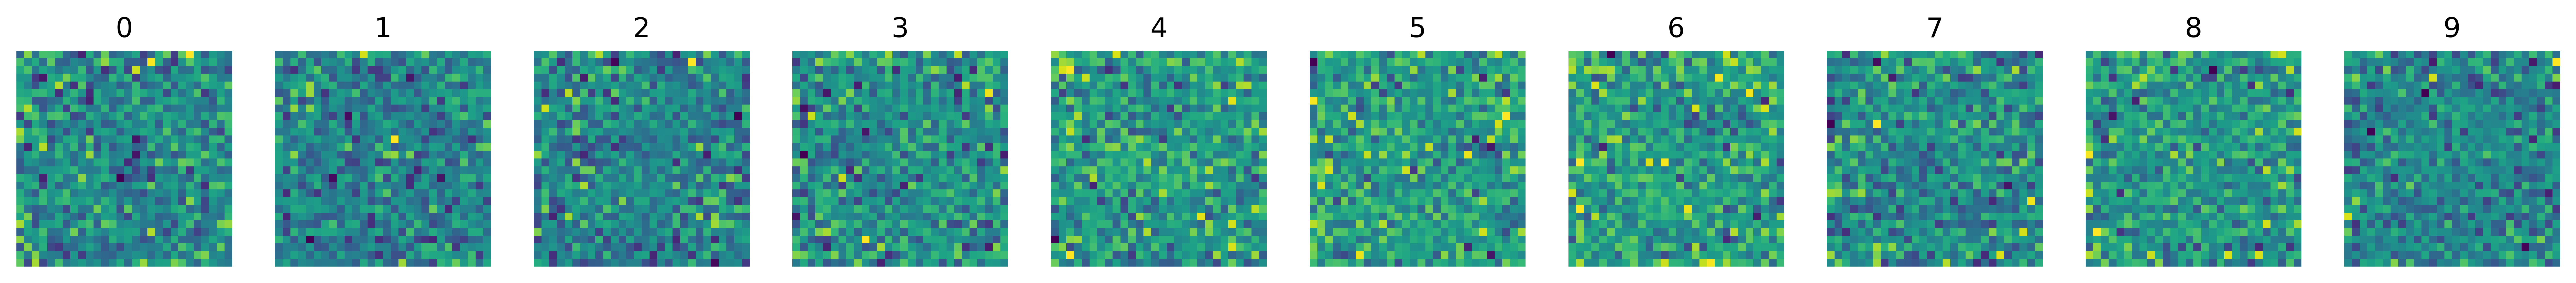

In [4]:
# load checkpoint and visualize weights
model=SVM()
model.load_checkpoint()
plt.rcParams['figure.figsize'] = [20, 20]
vis_weights([model.w])

# Train a model from scratch and visualize the weights

We train our model on the loss function
$$
\mathcal{L(\theta)}=\lambda R_2(\theta)+\frac{1}{N}\sum\limits_{i=1}^N \max(0, 1-y_if_\theta(x))
$$
The notes say to use the regularizer $\lambda$ to scale the hinge loss but it makes more sense to use it to scale the regularization term.

Found cached dataset mnist (/data/john/projects/svm/./datasets/mnist/mnist/1.0.0/fda16c03c4ecfb13f165ba7e29cf38129ce035011519968cdaf74894ce91c9d4)


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

<Figure size 2000x2000 with 0 Axes>

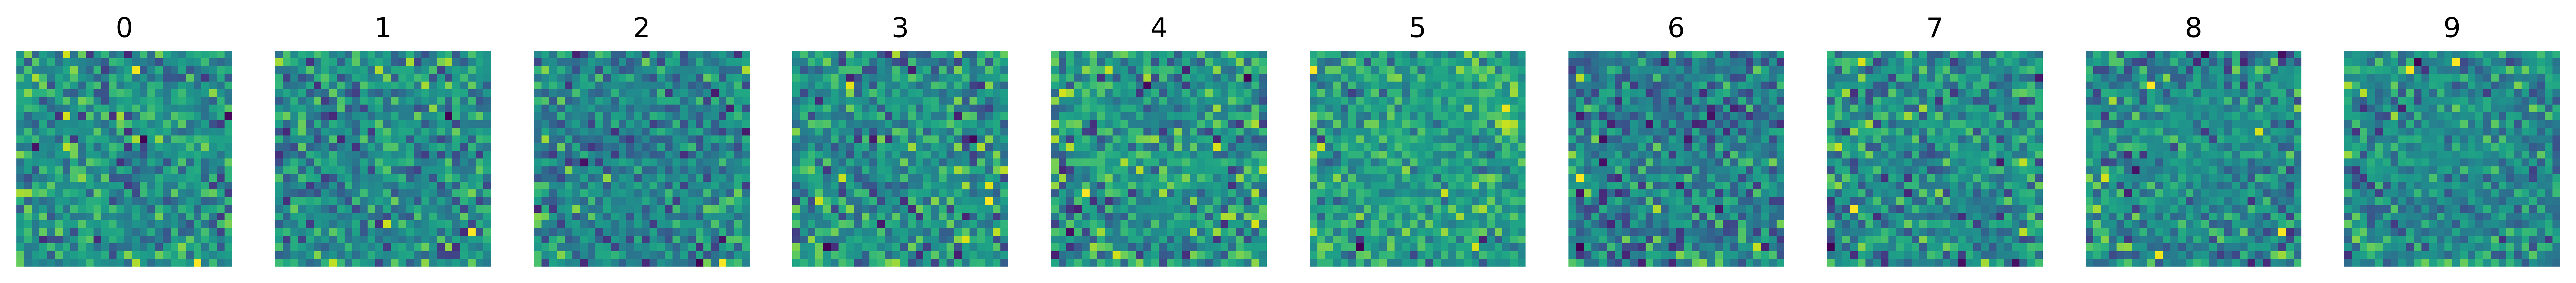

In [12]:
# train model
model, history = train(num_epochs=40)

# visualize weights
vis_weights([model.w])

# Visualize the weights throughout training history

### Train the model first!

The function `vis_weights` generates an image of how the weights during training. Changing `num_samples` increases the amount of samples to draw from the history. 

The samples are evenly spaced.

In [6]:
plt.rcParams['figure.figsize'] = [20, 20]
vis_weights(history['w'], num_samples=10)

<Figure size 2000x2000 with 0 Axes>

# Plot Data

### Train the model first!

Here we plot the loss, accuracy and $||w_t||$ over time. The blue line is for the training set and the orange line is for the test set

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0.01, 'iteration number')

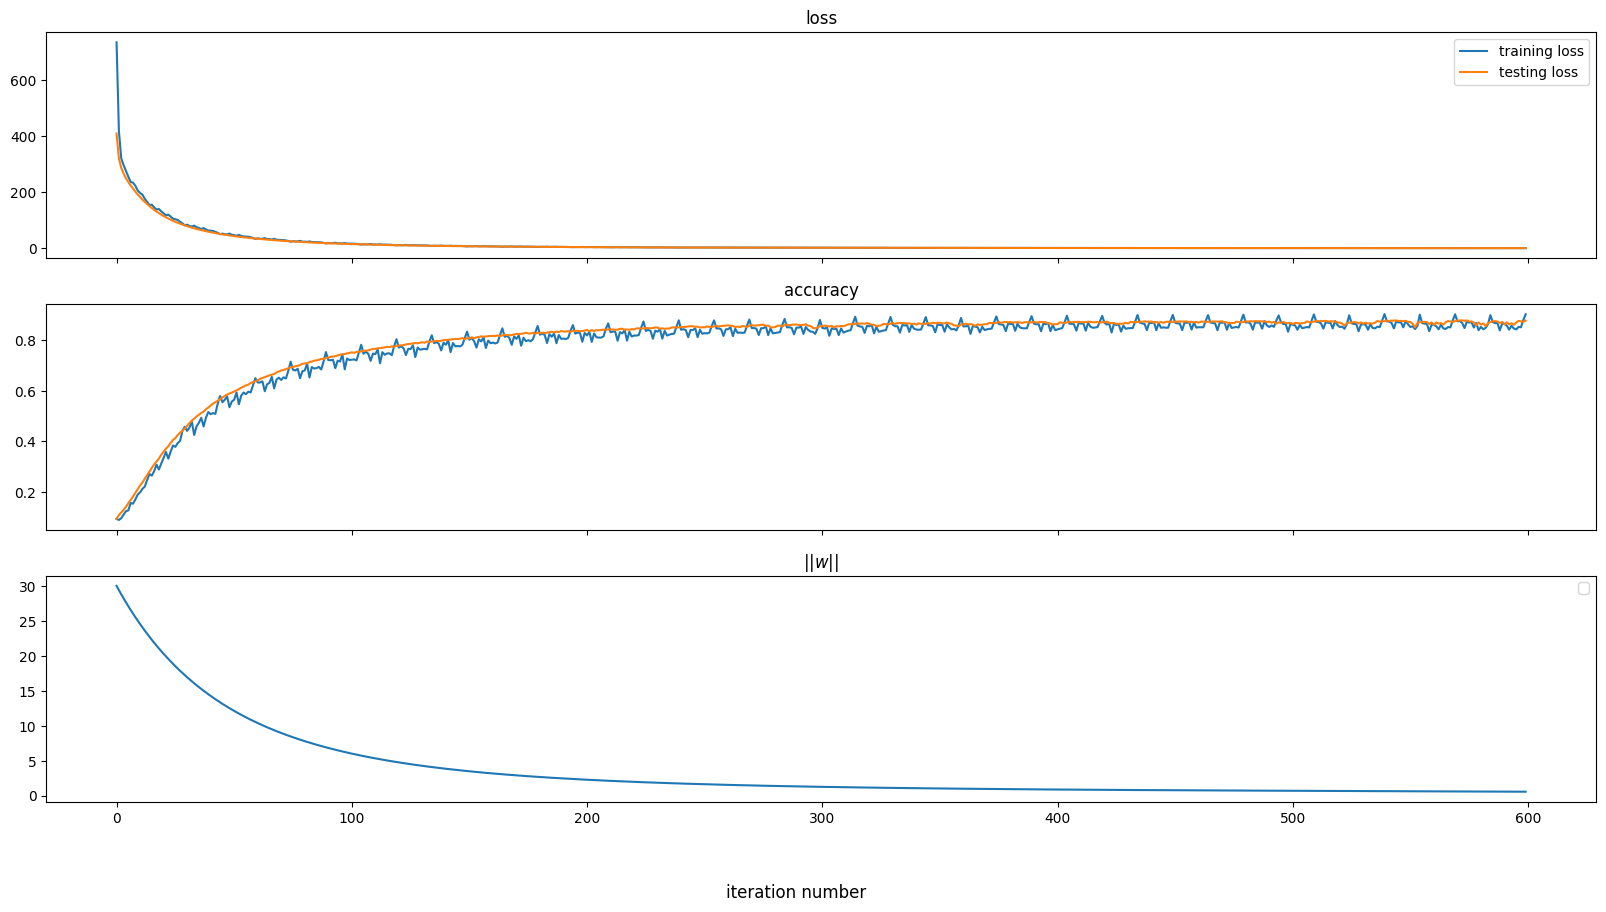

In [13]:
plt.rcParams['figure.figsize'] = [20, 10]

# get subplots
fig, ax = plt.subplots(3, 1, sharex=True)

x=len(history['train_loss'])
xi=range(x)

# plot loss
ax[0].plot(xi, history['train_loss'], label='training loss')
ax[0].plot(xi, history['test_loss'], label='testing loss')
ax[0].legend(loc='upper right')
ax[0].set_title('loss')

# plot accuracy
ax[1].plot(xi, history['train_acc'], label='training acc')
ax[1].plot(xi, history['test_acc'], label='testing acc')
ax[1].set_title('accuracy')

# plot l2 norm of weights\
norm_w=np.array([np.linalg.norm(w, ord=2) for w in history['w']])
ax[2].plot(xi, norm_w)
ax[2].set_title(r'$||w||$')

plt.legend()
fig.supxlabel('iteration number')

# Print the Accuracy and Confusion Matrix on the Test Set

We have a confusion matrix $C$ and its elements $C_{i,j}$ where $i$ is the row and $j$ is the column.  
Reads as "known as element $i$, and classified as $j$"

In [14]:
from sklearn.metrics import confusion_matrix

# make predictions on the test set
preds = model.predict(ds['test']['image'])

# display the accuracy
print(f'Accuracy on the test set: {np.mean(preds == ds["test"]["label"])}')

# display the confusion matrix
print(
    'Confusion matrix:\n' +
    f'{confusion_matrix(ds["test"]["label"], preds)}'
)


Accuracy on the test set: 0.8714
Confusion matrix:
[[ 941    0    3    6    0    7    8    1   11    3]
 [   0 1068    4    8    1    1    5    2   45    1]
 [  11    6  845   33   11    7   18   16   76    9]
 [   2    1   25  869    1   51    3    7   37   14]
 [   1    3   11    6  857    5   10    1   30   58]
 [  11    4    8   58    8  685   20    9   77   12]
 [  12    3   12    2   16   19  880    0   13    1]
 [   6    9   23   12    7    7    1  906   17   40]
 [   9    8    7   32   11   43    7   12  837    8]
 [  11    5    4   13   46   29    1   41   33  826]]


# Finally let's see what the model makes mistakes on

Execute the following code to randomly sample misclassified images from the testing set

9 mis-classified as 0


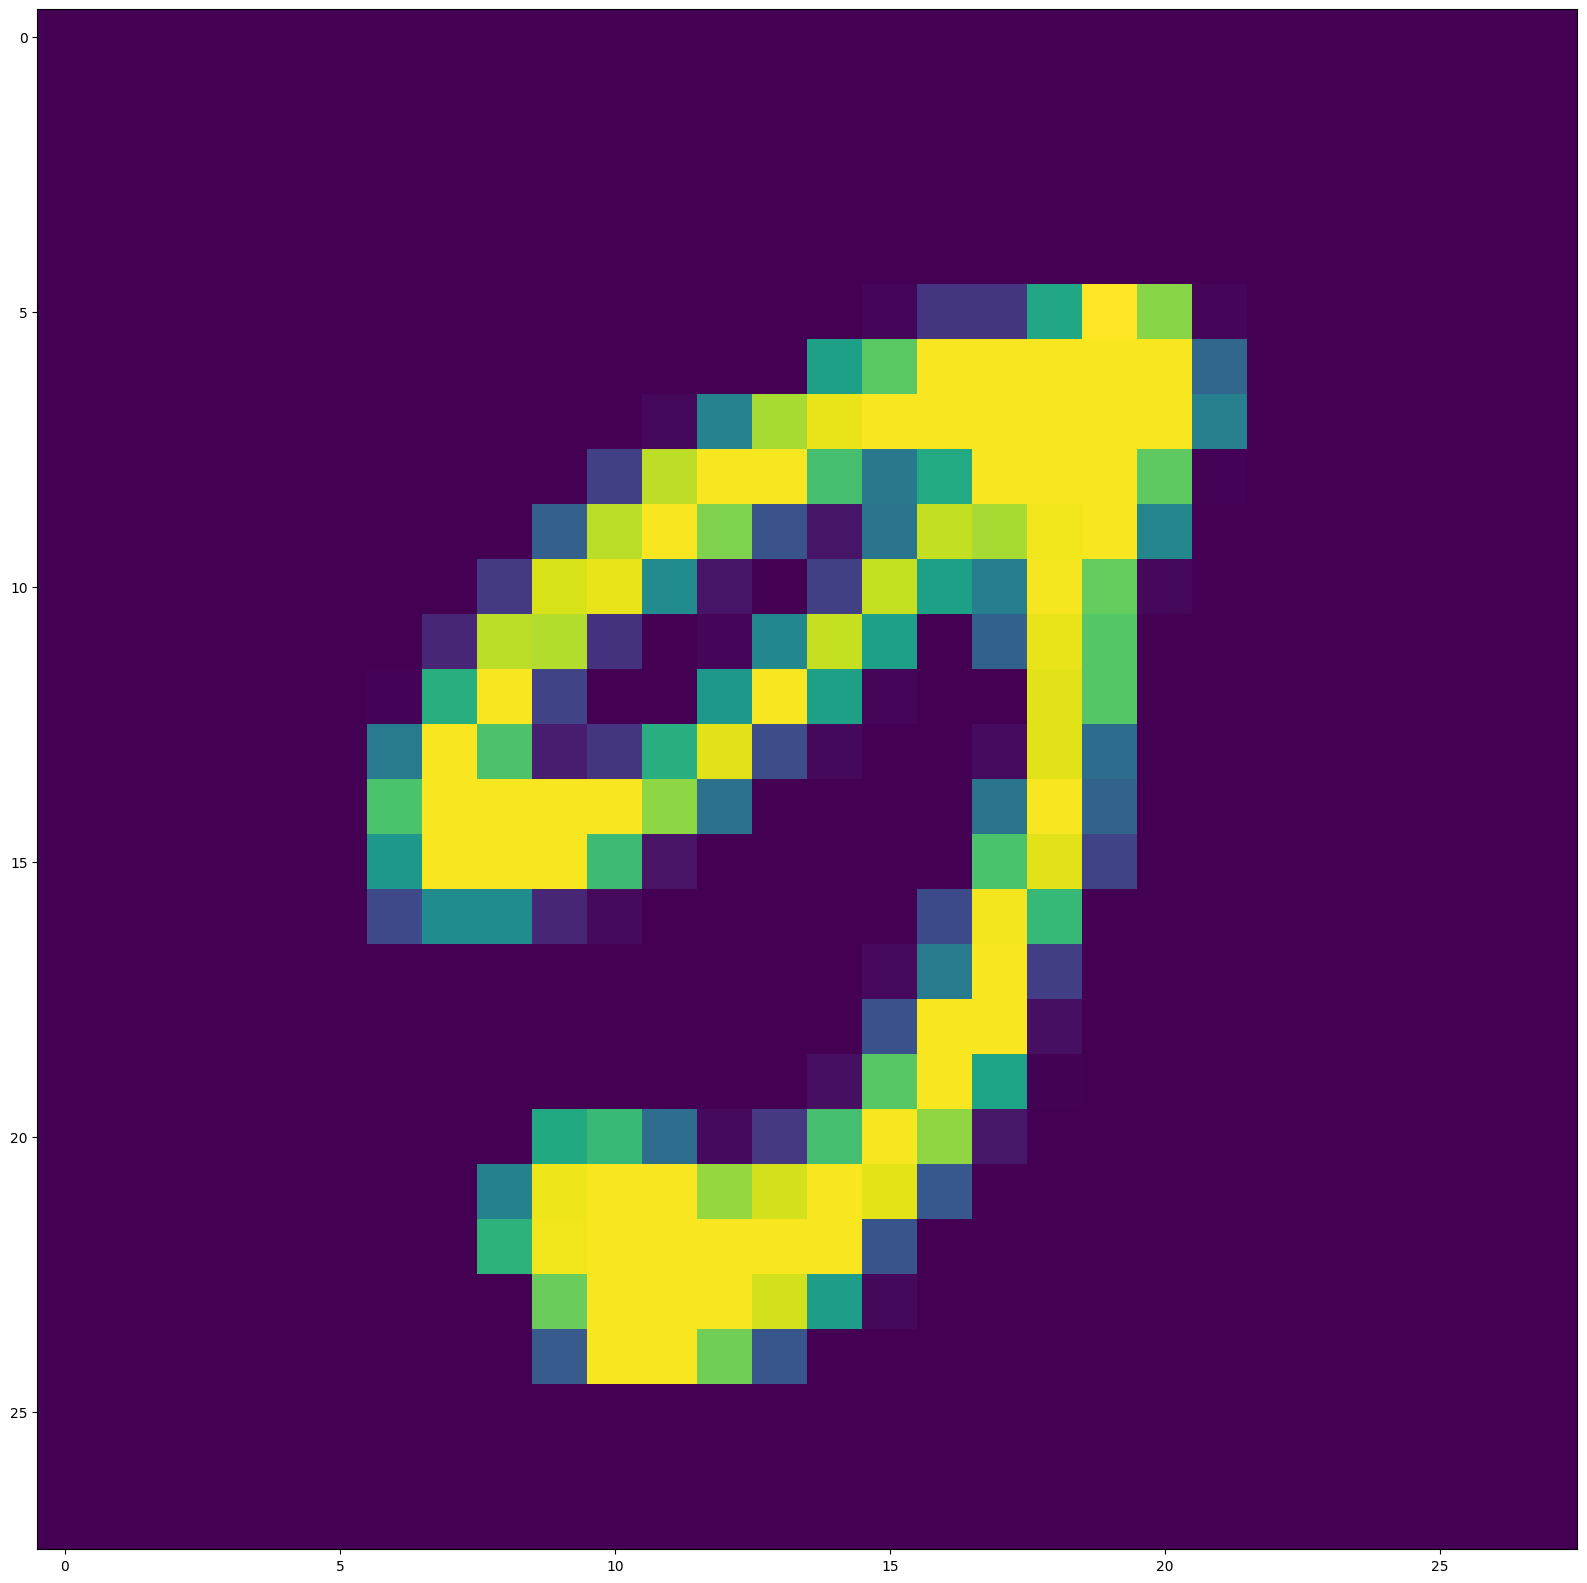

In [18]:
# run above first
plt.rcParams['figure.figsize'] = [20, 20]

# sample from the indeces of misclassified images and display the
# image and classification info
misclass_idx = np.where(preds != ds['test']['label'])[0]
sample_idx = np.random.choice(misclass_idx)
print(f'{ds["test"]["label"][sample_idx]} mis-classified as {preds[sample_idx]}')
plt.imshow(ds['test']['image'][sample_idx])